# Comparing Regression Algorithms - Part 2, Brute Force

### Brute Force

What is brute force in computing? It means trying everything. We will try every number in the least intelligent way possible. This is very bad. Even on Stampede, it's bad.

(As an aside there are some problems that there are few methods other than brute force that work. These unreducable problems in Computer Science are called `np hard` problems. Where if you have `n` elements that combine in `p` ways, you may still have to try every combination.)

### Generating some data

Let's make some random data that we want to fit. We are also going to cheat a little by knowing, ahead of time, what we want the `W` and `b` values to eventually be. (Note: due to the randomness in our data, this won't actually be the best fit line.)

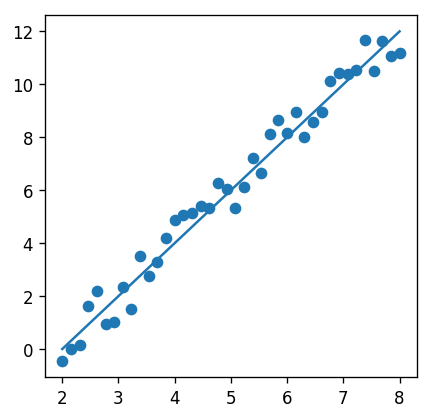

In [47]:
cheat_W = 2
cheat_b = -4

starting_value = 2
ending_value = 8
num_values = 40

x_vals = None
y_vals = None

# Let's make a graph!
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(num=None, figsize=(4, 4), dpi=120)


def make_vals(starting_value, ending_value, num_values):
    global x_vals
    global y_vals
    # Let's make a bunch of x values
    x_vals = np.linspace(starting_value, ending_value, num_values)
    # Let's make a bunch of y values close to our equation, but randomly off by a small amount
    y_vals = cheat_W * x_vals + cheat_b + np.random.uniform(-1, 1, 40)
    # Now plot them
    
make_vals(starting_value, ending_value, num_values)
    
plt.scatter(x_vals, y_vals)

# Let's plot our original line
x =  np.linspace(starting_value, ending_value, num_values)
# This equation creates our corresponding y values
cheat_y = cheat_W * x + cheat_b
# Now plot them as a straight line
plt.plot(x, cheat_y)

Let's also make a value to calculate our `loss`. When we call the function with our cheating values, we get a ballpark number for the possible `loss`.

In [48]:
def loss( target_y, current_y ):
    return np.sum(np.square(target_y - current_y))

print "loss, using our cheating values:", loss( y_vals, cheat_y )

loss, using our cheating values: 13.8038335136


### The worst way possible

Great! Now we know what the best possible loss is. But how do we get there? Let's try the worst algorithm possible, pretending for a second that we didn't know what `W` and `b` values we are searching for.

Here's our pseudocode:

```
Pretend our best loss is the highest floating point number that Python can store
Pretend our best W value is -10
Pretend our best b value is 10

for W values in the range of -10 to positive 10 with a certain number of steps in between
    for b values in the range of -10 to positive 10 with a certain number of steps in between
        calculate the loss for our given W and b values
        if this new loss is better than our best loss
            save the W value as the best W
            save the b value as the best b
            save the loss as our best loss
```

There are some obvious problems in our algorithm, other than speed. Can you guess what they are?

In [53]:
import numpy as np

def worst_regression(steps):
    best_loss = np.finfo(np.float32).max
    best_W = -10
    best_b = 10
    
    for W in np.linspace(-10, 10, steps):
        pass
        # Fill in the rest of the algorithm here
    
    print "best loss:", best_loss
    print "Equation: y =", best_W, "* x +", best_b

worst_regression(100)

best loss: 3.40282e+38
Equation: y = -10 * x + 10


### Exactly how terrible is it?

Well, the first way we can measure this method is by timing it.

In [54]:
import time

def measure_time(algorithm, steps):
    start = time.time()
    algorithm(steps)
    return time.time() - start
    
print "Execution time: ", measure_time(worst_regression, 100)

Execution time:  best loss: 3.40282e+38
Equation: y = -10 * x + 10
0.000406980514526


We only have 40 data points. If we attempt 100 steps for each value, it has small execution time. (On my laptop, it's about about a tenth of a second.) This isn't great, in modern computing terms. We also have really poor precision if we are only doing 100 steps from -10 to 10 for `W` and `b`. How does this algorithm scale with execution time? Let's get some experimental numbers and make some graphs!

best loss: 3.40282e+38
Equation: y = -10 * x + 10
best loss: 3.40282e+38
Equation: y = -10 * x + 10
best loss: 3.40282e+38
Equation: y = -10 * x + 10
best loss: 3.40282e+38
Equation: y = -10 * x + 10
best loss: 3.40282e+38
Equation: y = -10 * x + 10


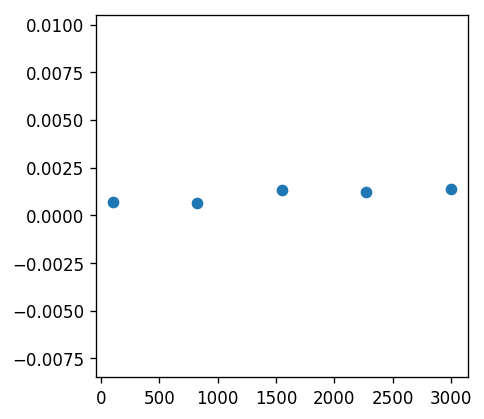

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(num=None, figsize=(4, 4), dpi=120)

def benchmark(algorithm, start, end, num):
    return zip(*[ ( steps, measure_time(algorithm, int(steps)) ) for steps in np.linspace(start, end, num)])

x_values, y_values = benchmark(worst_regression, 100, 3000, 5)

plt.scatter(x_values, y_values)

### What about best and worst case?

Let's see if we can optimize our algorithm. How about a "getting hotter" and "getting colder" approach to the inner loop?

```
for W between -10 and 10:
    our last_loss is the largest value (reset with each new W value)
    for b between -10 and 10
        make our guesses, calculate our loss
        if loss is less than our last_loss
            we are getting hotter so save this new loss value
        else
            we are getting colder so break out of this b loop early
```

In [21]:
def hotter_colder_regression(steps):
    best_loss = np.finfo(np.float32).max
    best_W = -10
    best_b = 10
    
    for W in np.linspace(-10, 10, steps):
        last_loss = np.finfo(np.float32).max
        for b in np.linspace(-10, 10, steps):
            guess_y = W * x_vals + b
            this_loss = loss(guess_y, y_vals)
            if this_loss < best_loss:
                best_loss = this_loss
                best_W = W
                best_b = b
            if this_loss < last_loss:
                last_loss = loss
            else:
                break
        # Fill in the rest of the algorithm here
    
    print "best loss:", best_loss
    print "Equation: y =", best_W, "* x +", best_b

print "Worst regression time: ", measure_time(worst_regression, 1000)
print "Hotter / Colder regression time: ", measure_time(hotter_colder_regression, 1000)

Worst regression time:  best loss: 46.9293605668
Equation: y = 1.41141141141 * x + -9.1991991992
8.9794049263
Hotter / Colder regression time:  best loss: 46.9293605668
Equation: y = 1.41141141141 * x + -9.1991991992
17.37144804


If this algorithm feels fishy, it should. It only really works well for linear relationships, and is dependent on always having the best value early in our guess region. Worst case scenario is if the best `b` value is always near the end of our `b` loop.

### Can't we just tell that it's bad by looking at it?

Yes! This is called order of complexity, which is an expression that describes how many times operations will run on `n` elements. For our purposes, we aren't scaling the number of data points, but we are scaling the number of steps. Therefore, we will say that `n` represents the number of steps. 

Generally speaking, if you have loops that iterate over `n` elements, nested loops raise the `n` to another power. This means that you have `n * n` steps, so the order of complexity of `O(n^2)`. The thing about "Big O" is that we don't care about best case scenarios or worst case scenarios or even actual execution time. We only want a snapshot of the complexity of this algorithm.

If we add another dimension to our relationship that we have to step through, the order of complexity will then become `O(n^3)`. What if we had to try to find an equation that fits in 3D space?!

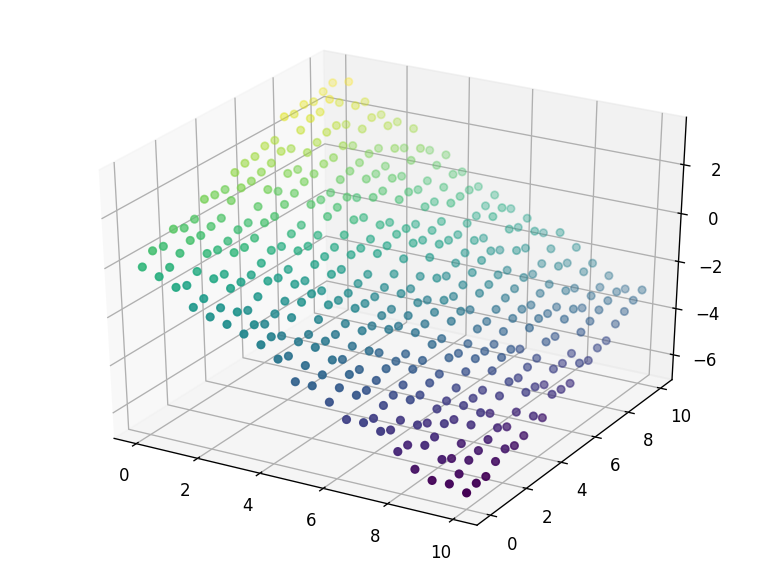

In [46]:
def generate_plane(a, b, c, noise):
    # Make an array of tuples of (x, y, z)
    coords = [(x , y, (a * x + b * y) / -c) for x in np.linspace(0, 10, 20) for y in np.linspace(0, 10, 20) ]
    # Return the "unzipped" tuples in 3 separate arrays
    x_vals, y_vals, z_vals = zip(*coords)
    # Add some noise to z
    z_vals += np.random.uniform(-noise, noise, len(x_vals))
    return x_vals, y_vals, z_vals

# Generate a plane
x_vals, y_vals, z_vals = generate_plane(2, -1, 3, 0.3)

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure(num=None, figsize=(8, 6),dpi=120)
axes = fig.add_subplot(111, projection='3d')
axes.scatter(xs=x_vals, ys=y_vals, zs=z_vals, c=z_vals, cmap=plt.cm.viridis)

### Next: [Comparing Regression Algorithms - Part 3, Optimization](Comparing Regression Algorithms - Part 3, Optimization.ipynb)